# Описание проекта

Мы работаем в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# План проекта

[Шаг 1. Загрузка библиотек, датасета, обработка данных](#step1)  

[Шаг 2. Изучение и проверка данных](#step2)  
   - [Шаг 2.1. Сколько всего событий/пользователей, сколько в среднем событий приходится на пользователя](#step3)  
   - [Шаг 2.2. С каким временным интервалом работать в дальнейшем](#step4)  
   
[Шаг 3. Изучение воронки событий](#step5)

   - [Шаг 3.1. Сортировка событий по числу пользователей, расчет доли пользователей для событий](#step6)  
   - [Шаг 3.2. Построение воронки событий, промежуточные выводы](#step7)
   
[Шаг 4. Изучение результатов A/A/B- тестов](#step8)

   - [Шаг 4.1. A/A - тест](#step9)  
   - [Шаг 4.2. A/B - тест](#step10)
   
[Шаг 5. Выводы](#step11)   

## Шаг 1. Загрузка библиотек, датасета, обработка данных <a id="step1"></a>  

In [3]:
import pandas as pd
import plotly.express as px 
import numpy as np
from plotly import graph_objects as go
from scipy import stats as st
import math as mth

df = pd.read_csv('/content/drive/MyDrive/проекты/сборный проект №2/logs_exp.csv', delimiter = '\t')

In [4]:
df

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [5]:
#переведем формат timestamp в привычную дату и время
from datetime import datetime
df['EventTimestamp'] = [datetime.fromtimestamp(x) for x in df['EventTimestamp']]

In [6]:
#добавим столбец с датой
df['date'] = df['EventTimestamp'].dt.date
#переименуем переменные
df = df.rename(columns={'EventName':'event', 'DeviceIDHash':'id', 'EventTimestamp':'date_time', 'ExpId':'expid'})

In [7]:
df

,event,id,date_time,expid,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


In [8]:
#проверим на пропуски
df.isna().sum()

event        0
id           0
date_time    0
expid        0
date         0
dtype: int64

In [9]:
#проверим на дубликаты
df.duplicated().sum()

413

In [10]:
#дубликатов меньше процента, можно от них избавиться
df = df.drop_duplicates()

Получили датасет, готовый к даьнейшей работе

## Шаг 2. Изучение и проверка данных <a id="step2"></a>

## Шаг 2.1. Сколько всего событий/пользователей, сколько в среднем событий приходится на пользователя <a id="step3"></a>

In [11]:
print('Всего событий в датасете:',df['event'].count())

Всего событий в датасете: 243713


In [12]:
print('Количество уникальных пользователей:',df['id'].nunique())

Количество уникальных пользователей: 7551


In [13]:
print('{:.0f} события в среднем приходится на одного пользователя '.format(df.groupby('id')['date_time'].count().reset_index()['date_time'].mean()))

32 события в среднем приходится на одного пользователя 


## Шаг 2.2. С каким временным интервалом работать в дальнейшем <a id="step4"></a>

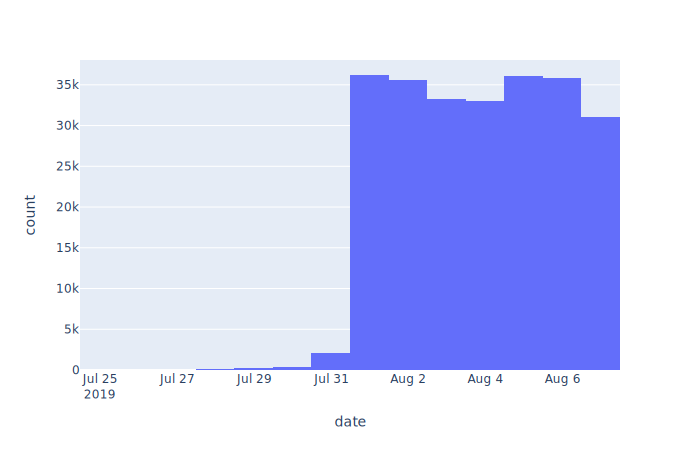

In [14]:
#построим гистограмму по датам
fig = px.histogram(df, x="date")
fig.show('svg')

По гистограмме видим,что данные становятся полными только с 1 августа, в дальнейшем будем работать именно с ними

In [15]:
df2 = df[df['date'] > pd.to_datetime('2019-07-31')]

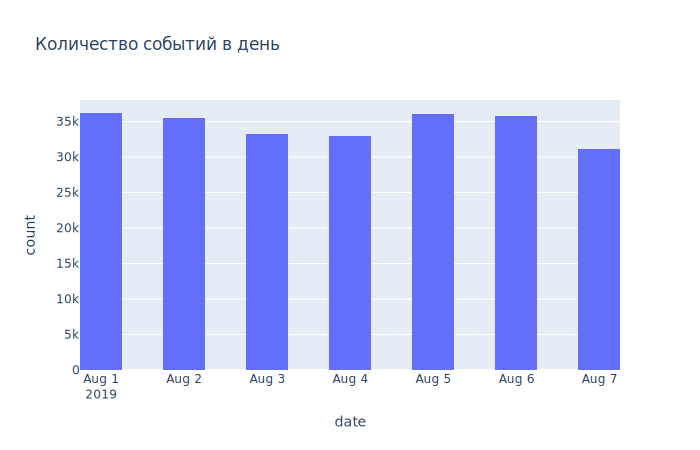

In [16]:
fig = px.histogram(df2, x="date", nbins = 20,
                  title = 'Количество событий в день')

fig.show('svg')

In [17]:
print(len(df) - len(df2), 'событий и', df['id'].nunique() - df2['id'].nunique(), 'пользователей было потеряно')

2826 событий и 17 пользователей было потеряно


In [18]:
print(round((len(df) - len(df2))/len(df), 3), '% событий и', round((df['id'].nunique() - df2['id'].nunique())/df['id'].nunique(),3), '% пользователей было потеряно')

0.012 % событий и 0.002 % пользователей было потеряно


In [19]:
print('Наличие пользователей в группах:')
print(df2.groupby('expid')['id'].nunique())

Наличие пользователей в группах:
expid
246    2484
247    2513
248    2537
Name: id, dtype: int64


## Шаг 3. Изучение воронки событий <a id="step5"></a>

## Шаг 3.1. Сортировка событий по числу пользователей, расчет доли пользователей для событий <a id="step5"></a>

In [20]:
events = df2.groupby('event')['id'].nunique().reset_index().sort_values(by = 'id', ascending = False)
events['perc'] = (events['id']/df2['id'].nunique()).round(3)
events

,event,id,perc
1,MainScreenAppear,7419,0.985
2,OffersScreenAppear,4593,0.610
0,CartScreenAppear,3734,0.496
3,PaymentScreenSuccessful,3539,0.470
4,Tutorial,840,0.111


Событие `Tutorial` скорее всего не относится к цепочке событий, исключим его

In [21]:
events = df2[df2['event'] != 'Tutorial'].groupby('event')['id'].nunique().reset_index().sort_values(by = 'id', ascending = False)
events['perc'] = (events['id']/df2[df2['event']!='Tutorial']['id'].nunique()).round(3)
events

,event,id,perc
1,MainScreenAppear,7419,0.985
2,OffersScreenAppear,4593,0.610
0,CartScreenAppear,3734,0.496
3,PaymentScreenSuccessful,3539,0.470


## Шаг 3.2. Построение воронки событий, промежуточные выводы <a id="step7"></a>

In [22]:
#для начала построим сводную таблицу
funnel = df2[df2['event'] != 'Tutorial'].pivot_table(
    index='id', 
    columns='event', 
    values='date_time',
    aggfunc='min')

In [23]:
#построим саму воронку
step_1 = ~funnel['MainScreenAppear'].isna()
step_2 = step_1 & (funnel['OffersScreenAppear'] > funnel['MainScreenAppear'])
step_3 = step_2 & (funnel['CartScreenAppear'] > funnel['OffersScreenAppear'])
step_4 = step_3 & (funnel['PaymentScreenSuccessful'] > funnel['CartScreenAppear'])
#посчитаем количество пользователей на каждом этапе
n_MainScreenAppear = funnel[step_1].shape[0]
n_OffersScreenAppear = funnel[step_2].shape[0]
n_CartScreenAppear = funnel[step_3].shape[0]
n_PaymentScreenSuccessfult = funnel[step_4].shape[0]

In [24]:
#выведем количество пользователей
print('MainScreenAppear:', n_MainScreenAppear)
print('OffersScreenAppear:', n_OffersScreenAppear)
print('CartScreenAppear:', n_CartScreenAppear)
print('PaymentScreenSuccessful:', n_PaymentScreenSuccessfult)

MainScreenAppear: 7419
OffersScreenAppear: 4201
CartScreenAppear: 1767
PaymentScreenSuccessful: 454


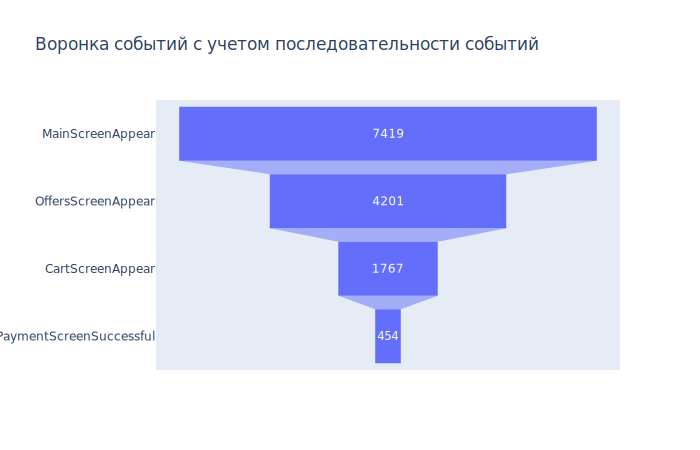

In [25]:
fig = go.Figure(go.Funnel(
    y = np.array(events['event']),
    x = [n_MainScreenAppear, n_OffersScreenAppear, n_CartScreenAppear, n_PaymentScreenSuccessfult])
)
fig.update_layout(
    title = {
        'text': 'Воронка событий с учетом последовательности событий'})
fig.show('svg')

In [26]:
no_chain = (
    df2[df2['event'] != 'Tutorial'].
    groupby('event')['id'].
    nunique().reset_index().
    sort_values(by='id', ascending = False)
)

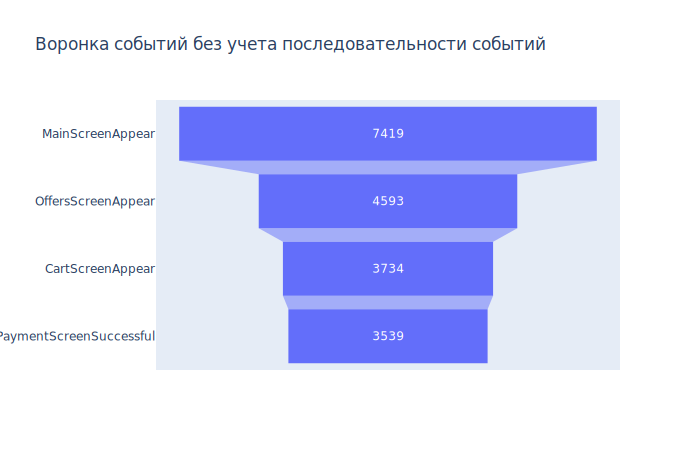

In [27]:
fig = go.Figure(go.Funnel(
    y = no_chain['event'],
    x = no_chain['id']))
fig.update_layout(
    title = {
        'text': 'Воронка событий без учета последовательности событий'})
fig.show('svg')

**Учитывая последовательность событий:**
- Наибольшее количество пользователей теряется при оплате (только `25,7%` от тех, кто заходил в корзину)  
- Всего `6,1%` пользователей проходят от начала до конца воронки

**Не учитывая последовательность событий**  
- Наибольшее количество пользователей теряется после просмотра главного экрана (порядка `40%`)
- На дальнейших событиях теряется очень мало пользователей и в целом покупки соврешают `47,7%` пользователей

## Шаг 4. Изучение результатов A/A/B- тестов <a id="step8"></a>  

In [28]:
print('Количество уникальных пользователей в каждой экспериментальной группе:')
print(df2.groupby('expid')['id'].nunique())

Количество уникальных пользователей в каждой экспериментальной группе:
expid
246    2484
247    2513
248    2537
Name: id, dtype: int64


In [29]:
#расчитаем количество и долю пользователей для каждого события и каждой группы
otvet246 = df2[df2['expid'] == 246].groupby('event')['id'].nunique().reset_index().sort_values(by= 'id',ascending = False)
otvet246['perc'] = (otvet246['id']/df2[(df2['expid'] == 246)]['id'].nunique()).round(3)
otvet246['group'] = 246

otvet247 = df2[df2['expid'] == 247].groupby('event')['id'].nunique().reset_index().sort_values(by= 'id',ascending = False)
otvet247['perc'] = (otvet247['id']/df2[(df2['expid'] == 247)]['id'].nunique()).round(3)
otvet247['group'] = 247

otvet248 = df2[df2['expid'] == 248].groupby('event')['id'].nunique().reset_index().sort_values(by= 'id',ascending = False)
otvet248['perc'] = (otvet248['id']/df2[(df2['expid'] == 248)]['id'].nunique()).round(3)
otvet248['group'] = 248

In [30]:
#т.к. в дальнейшем придется сравнивать экспериментальную группу с объедененной (2467), 
#то сразу расчитаем количество/долю пользователей для нее
otvet2467 = df2[df2['expid'] != 248].groupby('event')['id'].nunique().reset_index().sort_values(by= 'id',ascending = False)
otvet2467['perc'] = (otvet2467['id']/df2[(df2['expid'] != 248)]['id'].nunique()).round(3)
otvet2467['group'] = 2467

In [31]:
otvet = pd.concat([otvet246, otvet247],ignore_index=True)
otvet = pd.concat([otvet, otvet248],ignore_index=True)
otvet = pd.concat([otvet, otvet2467],ignore_index=True)

In [32]:
otvet.head()

,event,id,perc,group
0,MainScreenAppear,2450,0.986,246
1,OffersScreenAppear,1542,0.621,246
2,CartScreenAppear,1266,0.510,246
3,PaymentScreenSuccessful,1200,0.483,246
4,Tutorial,278,0.112,246


In [33]:
#найдем количество уникальных пользователей в объедененной группе
df2[(df2['expid'] != 248)]['id'].nunique()

4997

In [34]:
#создадим датасет с количеством пользователей
unique_users = df2.groupby('expid')['id'].nunique().reset_index()
unique_users = unique_users.append({'expid': 2467, 'id': 4997}, ignore_index=True)
unique_users = unique_users.rename(columns={'id':'whole', 'expid':'group'})

In [35]:
otvet = otvet.merge(unique_users, on = 'group', how = 'left')

In [36]:
otvet.head()

,event,id,perc,group,whole
0,MainScreenAppear,2450,0.986,246,2484
1,OffersScreenAppear,1542,0.621,246,2484
2,CartScreenAppear,1266,0.510,246,2484
3,PaymentScreenSuccessful,1200,0.483,246,2484
4,Tutorial,278,0.112,246,2484


Перед проведением теста сформулируем гипотезы: 

H0 - Нет оснований считать доли разными

H1 - Между долями есть значимая разница

In [37]:
#т.к. придется много раз проводить A/B - тест, запишем его в функцию
def check(first_group, second_group, event):
    
  alpha = .05

  fraction = (
      float(otvet[(otvet['event'] == event) & (otvet['group'] == first_group)]['id']), 
      float(otvet[(otvet['event'] == event) & (otvet['group'] == second_group)]['id'])
  )
  whole = (
      float(otvet[(otvet['event'] == event) & (otvet['group'] == first_group)]['whole']), 
      float(otvet[(otvet['event'] == event) & (otvet['group'] == second_group)]['whole'])
  )

  p1 = fraction[0]/whole[0]
  p2 = fraction[1]/whole[1]
  p_combined = (fraction[0] + fraction[1])/(whole[0] + whole[1])
  difference = p1 - p2 


  z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/whole[0] + 1/whole[1]))
  distr = st.norm(0, 1)

  p_value = (1 - distr.cdf(abs(z_value))) * 2

  print('p-значение: ', p_value)
  if (p_value < alpha):
      print('Отвергаем нулевую гипотезу: между долями события ',event, 'есть значимая разница')
  else:
      print('Принимаем нулевую гипотезу, нет оснований считать доли события', event, 'разными')
  print()      

In [38]:
#сравним все события групп 246 и 247
for i in events['event']:
    check(246,247,i)

p-значение:  0.7570597232046099
Принимаем нулевую гипотезу, нет оснований считать доли события MainScreenAppear разными

p-значение:  0.2480954578522181
Принимаем нулевую гипотезу, нет оснований считать доли события OffersScreenAppear разными

p-значение:  0.22883372237997213
Принимаем нулевую гипотезу, нет оснований считать доли события CartScreenAppear разными

p-значение:  0.11456679313141849
Принимаем нулевую гипотезу, нет оснований считать доли события PaymentScreenSuccessful разными



In [39]:
#сравним все события групп 246 и 248
for i in events['event']:
    check(246,248,i)

p-значение:  0.2949721933554552
Принимаем нулевую гипотезу, нет оснований считать доли события MainScreenAppear разными

p-значение:  0.20836205402738917
Принимаем нулевую гипотезу, нет оснований считать доли события OffersScreenAppear разными

p-значение:  0.07842923237520116
Принимаем нулевую гипотезу, нет оснований считать доли события CartScreenAppear разными

p-значение:  0.2122553275697796
Принимаем нулевую гипотезу, нет оснований считать доли события PaymentScreenSuccessful разными



In [40]:
#сравним все события групп 247 и 248
for i in events['event']:
    check(247,248,i)

p-значение:  0.4587053616621515
Принимаем нулевую гипотезу, нет оснований считать доли события MainScreenAppear разными

p-значение:  0.9197817830592261
Принимаем нулевую гипотезу, нет оснований считать доли события OffersScreenAppear разными

p-значение:  0.5786197879539783
Принимаем нулевую гипотезу, нет оснований считать доли события CartScreenAppear разными

p-значение:  0.7373415053803964
Принимаем нулевую гипотезу, нет оснований считать доли события PaymentScreenSuccessful разными



In [41]:
#сравним все события групп 2467 и 248
for i in events['event']:
    check(2467,248,i)

p-значение:  0.29424526837179577
Принимаем нулевую гипотезу, нет оснований считать доли события MainScreenAppear разными

p-значение:  0.43425549655188256
Принимаем нулевую гипотезу, нет оснований считать доли события OffersScreenAppear разными

p-значение:  0.18175875284404386
Принимаем нулевую гипотезу, нет оснований считать доли события CartScreenAppear разными

p-значение:  0.6004294282308704
Принимаем нулевую гипотезу, нет оснований считать доли события PaymentScreenSuccessful разными



## Шаг 5. Выводы <a id="step11"></a>  

- Была проведена предобработка исходного датасета, изменен тип данных, удалены дубликаты, переименованны переменные  
- Определили, что `данные за июль не полные`, в них входили всего `2826 событий и 17 пользователей`, в дальнейше работе их не использовали  
- Самым популярным событием является `MainScreenAppear`. Общее число и доля пользователей совершивших его `7419` и `38,5%` соответственно  
- Событие `Tutorial` не встраивается в последовательную цепочку событий, не учитываем его при построении воронки  
- Наибольшая доля пользователей теряется на этапе оплаты (`74,3%` тех, кто перешел в корзину) и всего `6,1%` пользователей доходит от первого события до оплаты  
- Между группами `246` и `247` нет статистически значимых отличий, что в свою очередь говорит о корректном разбиении на группы 
- Статистически значимых отличий не обнаружено, как между группами `246 - 248`, `247 - 248`, так и между объедененной `2467` и экспериментальной `248` группой. Это говорит о том, что увеличение шрифта не вызвало каких-то изменений в поведении пользователей